In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cProfile
from profile_processing import ProfileStats, get_call_stats

`profile_processing` helps when we want to create multiple profiles and extract data from each of them.
Profile stats is a simple wrapper around the built-in `pstats.Stats` class in Python.

In [2]:
os.mkdir('numpy_dot_profiles')  # Create a directory for our profiles
sizes = range(100, 1100, 100)  # Let's analyze matrices of various sizes.

We create profiles for `np.linalg.eig` on matrices of growing size.

In [4]:
rng = np.random.default_rng(42)
for s in sizes:
    matrix = rng.random((s, s), dtype=np.float64)
    profile_path = f'numpy_dot_profiles/{s}.prof'
    cProfile.run('np.linalg.eig(matrix)', profile_path)

Load one of the profiles and list all functions that were being called.

In [5]:
profile = ProfileStats('numpy_dot_profiles/100.prof')
profile.list_calls()

["<method 'get' of 'dict' objects>",
 "<method 'items' of 'dict' objects>",
 '<built-in method builtins.exec>',
 '<built-in method builtins.getattr>',
 '<built-in method builtins.issubclass>',
 "<method 'disable' of '_lsprof.Profiler' objects>",
 '<dictcomp>',
 '_wrapreduction',
 '_all_dispatcher',
 'all',
 '_all',
 'all',
 'get_linalg_error_extobj',
 '_makearray',
 'isComplexType',
 '_realType',
 '_complexType',
 '_commonType',
 '_assert_stacked_2d',
 '_assert_stacked_square',
 '_assert_finite',
 '_unary_dispatcher',
 'eig',
 'eig',
 "<method '__array_prepare__' of 'numpy.ndarray' objects>",
 "<method 'all' of 'numpy.ndarray' objects>",
 "<method 'astype' of 'numpy.ndarray' objects>",
 '<built-in method numpy.asarray>',
 '<built-in method numpy.core._multiarray_umath.implement_array_function>',
 "<method 'reduce' of 'numpy.ufunc' objects>",
 '<module>']

Say we are interested in the `isComplexType` function and how its runtimes differ for growing matrix sizes.

All the profile data inside `pstats.Stats` is stored in the `stats` attribute which is a dictionary. We can search for the key for the function we are interested in.

In [6]:
keys = profile.search_calls(name_pattern='isComplexType')
keys

[('/Users/frederik.wilde/pennylane/venv3.10-dev/lib/python3.10/site-packages/numpy/linalg/linalg.py',
  117,
  'isComplexType')]

The key contains a file path, the line number, and function name. `search_call` also allows you to search by `path_pattern` or the `line_number`.

The corresponding value contains statistics about the calls to this function:

In [7]:
profile.get_call(key=keys[0])

{'ncalls_prim': 3,
 'ncalls': 3,
 'tottime': 3.2500000000000002e-06,
 'cumtime': 4.5e-06,
 'callers': {('/Users/frederik.wilde/pennylane/venv3.10-dev/lib/python3.10/site-packages/numpy/linalg/linalg.py',
   136,
   '_commonType'): (1, 1, 1.3750000000000002e-06, 1.667e-06),
  ('/Users/frederik.wilde/pennylane/venv3.10-dev/lib/python3.10/site-packages/numpy/linalg/linalg.py',
   1182,
   'eig'): (2, 2, 1.875e-06, 2.8330000000000002e-06)}}

We could also just use `profile.stats[keys[0]]` here instead, but we would get an uninformative tuple of numbers.

Now we can extract the information we are interested in from profile files with a single line of code with `get_call_stats` and load it into a Pandas `DataFrame`.

In [8]:
table = []
for s in sizes:
    call = get_call_stats(f'numpy_dot_profiles/{s}.prof', 'isComplexType')
    table.append((f'{s} x {s}', call['ncalls'], call['cumtime']))
df = pd.DataFrame(table, columns=('Matrix size', 'Number of calls', 'Cumulative time'))
df

,Matrix size,Number of calls,Cumulative time
0,100 x 100,3,0.000005
1,200 x 200,3,0.000005
2,300 x 300,3,0.000003
3,400 x 400,3,0.000002
4,500 x 500,3,0.000003
5,600 x 600,3,0.000002
6,700 x 700,3,0.000003
7,800 x 800,3,0.000003
8,900 x 900,3,0.000004
9,1000 x 1000,3,0.000003


We can easily plot results extracted from different profiles now.

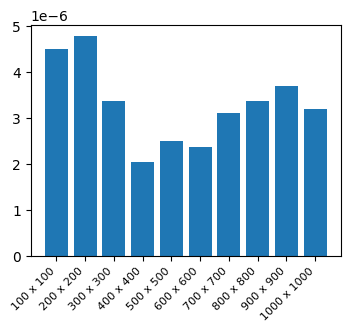

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
x = range(len(sizes))
ax.bar(x, df['Cumulative time'])
ax.set_xticks(x)
ax.set_xticklabels(df['Matrix size'], rotation=45., ha='right', fontsize=8)
plt.show()
# plt.savefig('stats-plot.png', bbox_inches='tight')